All code just needs to be run in the jupyter environment. You need standard libraries like seaborn, scipy, pandas, and np installed.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import cm, mlab
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

# 1

## a

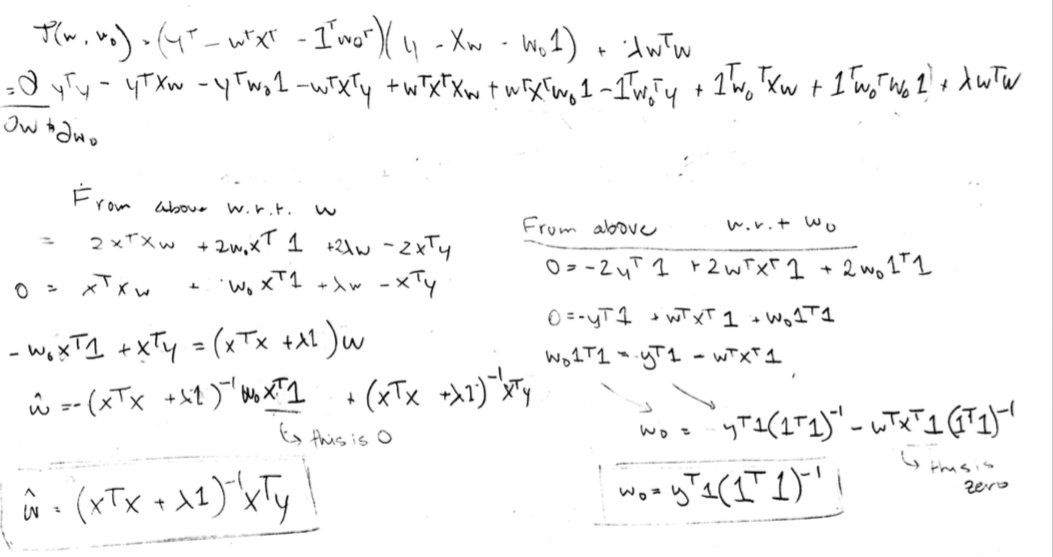

In [2]:
Image(filename="1a.png")

**Notes**
we know that $X^T1$ is 0 because the mean is 0.

## b

In [3]:
housing_data = scipy.io.loadmat("data/housing_data.mat")
raw_x_train = pd.DataFrame(housing_data['Xtrain'])
raw_y_train = pd.DataFrame(housing_data['Ytrain'])
raw_x_validate = pd.DataFrame(housing_data['Xvalidate'])
raw_y_validate = pd.DataFrame(housing_data['Yvalidate'])
print(raw_x_train.shape, raw_y_train.shape)
print( raw_x_validate.shape,raw_y_validate.shape)

(19440, 8) (19440, 1)
(1200, 8) (1200, 1)


In [4]:
# raw_x_train[9] = 1 # bias term or normalize :)
# raw_x_validate[9] = 1
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler(with_std=False).fit(X_train)
# print(scaler)
# X_train = scaler.transform(raw_x_train.values)
# X_val = scaler.transform(raw_x_validate.values)
means = raw_x_train.values.mean(axis=0)

X_train = raw_x_train.values - np.array([means for x in range(len(raw_x_train.values))])
y_train = raw_y_train.values


X_val = raw_x_validate.values - np.array([means for x in range(len(raw_x_validate.values))])
y_val = raw_y_validate.values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(19440, 8) (19440, 1)
(1200, 8) (1200, 1)


In [5]:
def kfolds(X, y, n_folds):
    chunk_size = len(X)/n_folds
    chunks = [(chunk_size * x, chunk_size * (x+1)) for x in range(n_folds)]
    for start, end in chunks:
        sub_X = np.concatenate([X[:start], X[end:]])
        sub_y = np.concatenate([y[:start], y[end:]])
        other_X = X[start:end]
        other_y = y[start:end]
        yield sub_X, sub_y, other_X, other_y
        
def get_results(y_hat, y_val):
    rss = np.sum((y_val - y_hat) ** 2)
    tss = np.sum((y_val - np.mean(y_val)) ** 2)
    r_sqrd = 1 - (rss/tss)
    return rss, r_sqrd

def train_model(X, y, lamb):
    lamby = lamb * np.ones(len(X.T))
    front = np.dot(X.T, X)
    invert_me = front + lamby
    inv = np.linalg.inv(invert_me)
    return inv.dot(np.dot(X.T, y))

# w = np.dot(np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), X_train.T), y_train)
# print(w.reshape((9,)))
# y_hat = np.dot(X_val,w)

In [6]:
all_scores = {}
for lamb in [10, 10e-1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8]:
    print("Lambda Value: ", lamb)
    scores = []
    for count, (X_1, y_1, X_2, y_2) in enumerate(kfolds(X_train, y_train, 10)):
        w = train_model(X_1, y_1, lamb)
        y_hat = np.dot(X_2, w)
        rss, r_sqrd = get_results(y_hat, y_2)
        scores.append(rss)
    print("Mean RSS of: %.2f and variance of %.2f" % (np.array(scores).mean(), np.array(scores).var()))
    all_scores[lamb] = scores

Lambda Value:  10
Mean RSS of: 92710448243753.16 and variance of 2032134469965135992586240.00
Lambda Value:  1.0
Mean RSS of: 92710539639546.80 and variance of 2029584036405399779278848.00
Lambda Value:  0.1
Mean RSS of: 92710549864972.42 and variance of 2029327750219693341802496.00
Lambda Value:  0.01
Mean RSS of: 92710550898494.22 and variance of 2029302109118090216210432.00
Lambda Value:  0.001
Mean RSS of: 92710551001956.33 and variance of 2029299544883034509541376.00
Lambda Value:  0.0001
Mean RSS of: 92710551012303.61 and variance of 2029299288458291344048128.00
Lambda Value:  1e-05
Mean RSS of: 92710551013338.38 and variance of 2029299262815797109587968.00
Lambda Value:  1e-06
Mean RSS of: 92710551013441.84 and variance of 2029299260251535472328704.00
Lambda Value:  1e-07
Mean RSS of: 92710551013452.19 and variance of 2029299259995115187339264.00


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
pd.DataFrame(all_scores).mean(axis=0)

1.000000e-07    9.271055e+13
1.000000e-06    9.271055e+13
1.000000e-05    9.271055e+13
1.000000e-04    9.271055e+13
1.000000e-03    9.271055e+13
1.000000e-02    9.271055e+13
1.000000e-01    9.271055e+13
1.000000e+00    9.271054e+13
1.000000e+01    9.271045e+13
dtype: float64

In [8]:
best_lambda = pd.DataFrame(all_scores).mean(axis=0).idxmin()
print(best_lambda)
print("Best Lambda Value:", best_lambda)

10.0
Best Lambda Value: 10.0


In [9]:
pd.DataFrame(all_scores).min(axis=0)

1.000000e-07    8.989462e+13
1.000000e-06    8.989462e+13
1.000000e-05    8.989462e+13
1.000000e-04    8.989462e+13
1.000000e-03    8.989462e+13
1.000000e-02    8.989462e+13
1.000000e-01    8.989460e+13
1.000000e+00    8.989446e+13
1.000000e+01    8.989300e+13
dtype: float64

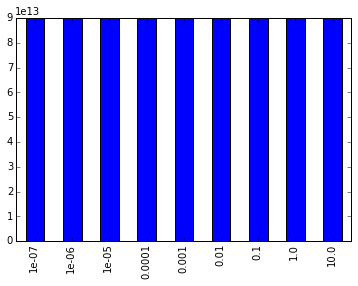

In [10]:
pd.DataFrame(all_scores).min(axis=0).plot(kind='bar')

Best Lambda Value: 10.0
RSS: 55,472,726,037,902. Old RSS: 5,794,953,797,676, difference: 49,677,772,240,226
Range of y Hat Values => Min: -263237 Max: 504108
Range of True Y Values => Min: 28300 Max: 500001
R^2: -2.417


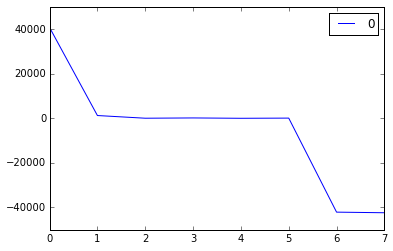

In [11]:
ws = train_model(X_train, y_train, best_lambda)
y_hat = np.dot(X_val, ws)
pd.DataFrame(ws[:8]).plot() # removed bias
rss = np.sum((y_val - y_hat) ** 2)
tss = np.sum((y_val - np.mean(y_val)) ** 2)
r_sqrd = 1 - (rss/tss)
print("Best Lambda Value:", best_lambda)
import locale
locale.setlocale(locale.LC_ALL, 'en_US')
old = locale.format("%i", 5794953797676, grouping=True)
new = locale.format("%i", rss, grouping=True)
diff = locale.format("%i", rss - 5794953797676, grouping=True)
print("RSS: %s. Old RSS: %s, difference: %s" % (new, old, diff))
print("Range of y Hat Values => Min: %i Max: %i" %(min(y_hat), max(y_hat)))
print("Range of True Y Values => Min: %i Max: %i" %(min(y_val), max(y_val)))
print("R^2: %.3f" % r_sqrd)

## HW3 Plot
We can see that they're roughly the same except for the fact that the newer graph is just a but more squished in - which is what we would expect from using shrinkage.

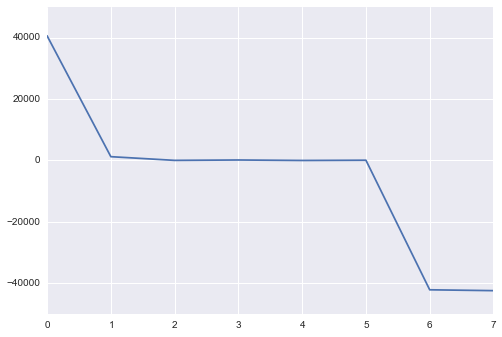

In [12]:
Image(filename='hw3_plot.png') 

error terms for hw3.

# 2

## 2.a 

$$1/36$$


## 2.b

$$ p  + (1 - p) = 1 $$
$$ p^* = 1 - (1 - p)^3 $$
$$ p^* = 1 - (35/36)^3 $$
$$ p^* = .081039952 $$

## 2.c

I've figured out it's one of two things (I've heard difference answers from the GSIs as to their correctness).

It is either 203/1000.

OR

Here's what we need to calculate.

$$ P(x \leq 203) = (1000 choose 203) 0.5 ^{203} (1-0.5)^{1000-203} $$

However this is obviously inefficient computationally, so we've got to approximate the binomial with the normal distribution with the continuity correction.


In [13]:
n = 1000
p = 0.5
mu = n * p
sigma = np.sqrt(1000 * 0.5 * (1-0.5))
z = (203.5 - mu)/sigma
print(z)

-18.7523065248


The $ p < 0.00001 $ making it a simple matter to reject the null hypothesis[that there is no difference between the errors of our algorithm and our competitors].



## 2.d 
With more trials, we are more likely to get a 0.05 p-value or lower. Therefore we cannot reject the null hypothesis without adjusting our critical value accordingly.

## 2.e
Just like with our dice roll above, with repeated trails we are changing the probabilities. We're effectively rolling the dice several times and we've got to correct for that.

$$ p_{significant} + p_{not-significant} = 1$$

$$p_s = 1 - (1 - p_s)^m$$

Just like above, as $m$ increases $(1-p_s)$ will approach 0 and $p_s$ will approach 1. We can correct for this by  multiplying our returned p-value by m trials. As m increases to infinity, this will cause p_s to now approach zero, eliminating any possible chance of false discovery rate (and consequentially positive rates). That is to say, the Bonferroni correction prevents false positives, but doesn't prevent false negatives. This is why it's often called too conservative.

We can get this from the binomial expansion as well, the Bonferroni Correction allows you to "grab" the first and most significant step in the binomial expansion and scale according to that. It's not a "perfect correction" but it's a good one.


## 2.f

Although we get a small value, due to the Bonferroni Correction, this gene is not significant because we get a p-value of 5. A p-value of 5 shows us that the Bonferroni correction acts as an upper bound on our probability. Because the corrected p value is so high, we cannot reject the null hypothesis.

# 3

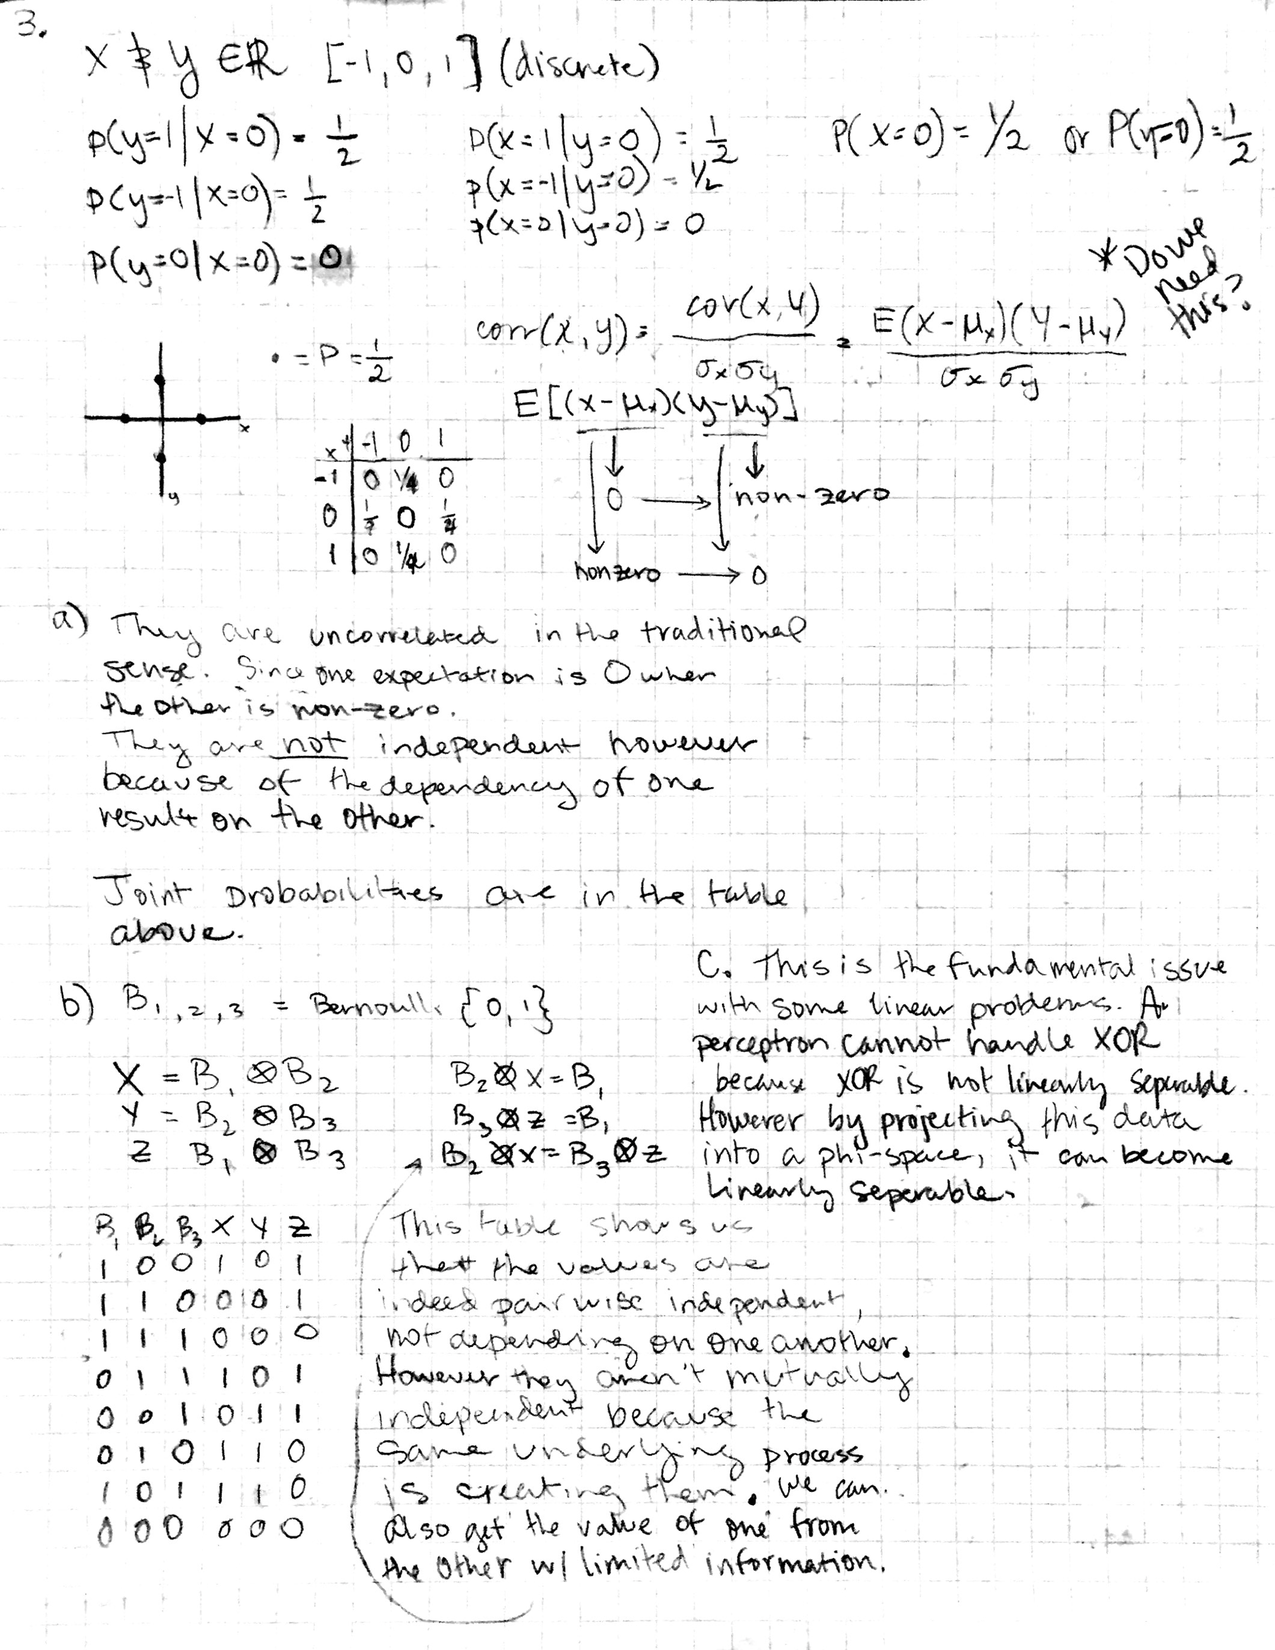

In [14]:
Image("3.png")

## 3.c (part 2)

These questions are relevant because they show us that even if things can be pairwise independent, they may not be mutually independent or they may have some hidden dependencies between one another. Commonly known as the XOR problem, where the data is not independent and linearly seperable because they are mutually dependent.

A data set that would reflect this would be where a companies best customers are either young and male or old and female, but not both. This dataset is not linearly separable in the conventional space by a method like a perceptron. However this might be linearly seperable in some phi-space, which is why we might approach this kind of problem with a kernel.

# 4

## 4.a

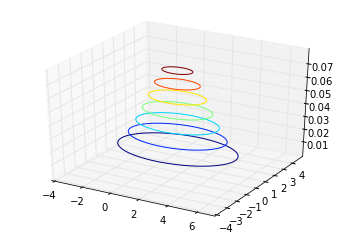

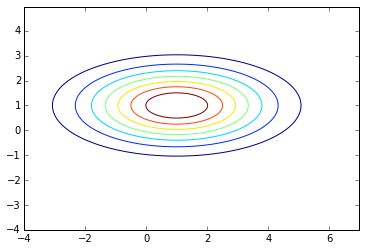

In [15]:
delta = 0.025
x = np.arange(-4.0, 7.0, delta)
y = np.arange(-4.0, 5.0, delta)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, sigmax=2, sigmay=1.0, mux=1, muy=1, sigmaxy=0.0)
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.b

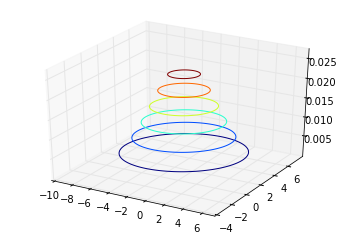

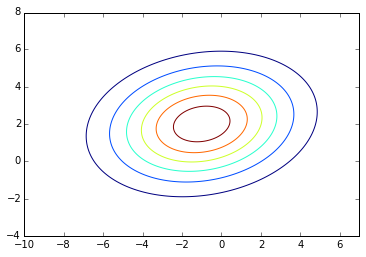

In [16]:
delta = 0.025
x = np.arange(-10.0, 7.0, delta)
y = np.arange(-4.0, 8.0, delta)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, sigmax=3, sigmay=2.0, mux=-1, muy=2, sigmaxy=1.0)
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.c

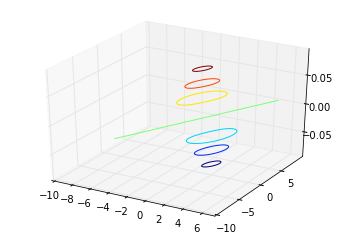

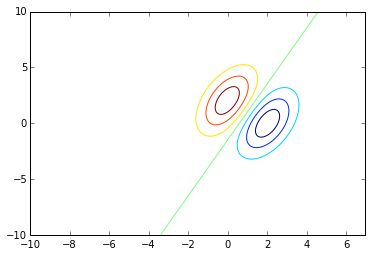

In [17]:
delta = 0.025
x = np.arange(-10.0, 7.0, delta)
y = np.arange(-10.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=0, muy=2, sigmaxy=1.0)
Z2 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=2, muy=0, sigmaxy=1.0)
Z = Z1 - Z2
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.d

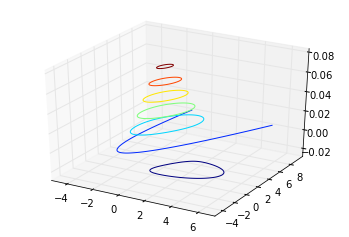

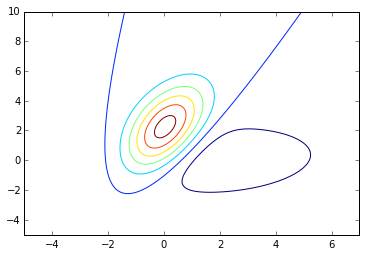

In [18]:
delta = 0.025
x = np.arange(-5.0, 7.0, delta)
y = np.arange(-5.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=0, muy=2, sigmaxy=1.0)
Z2 = mlab.bivariate_normal(X, Y, sigmax=3, sigmay=2.0, mux=2, muy=0, sigmaxy=1.0)
Z = Z1 - Z2
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.e

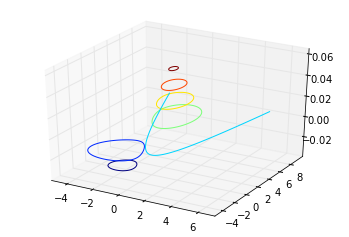

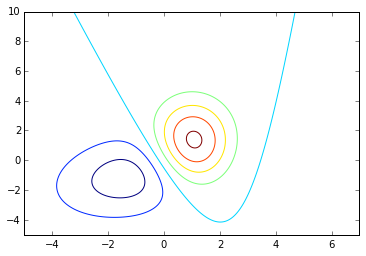

In [19]:
delta = 0.025
x = np.arange(-5.0, 7.0, delta)
y = np.arange(-5.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=1, muy=1, sigmaxy=0.0)
Z2 = mlab.bivariate_normal(X, Y, sigmax=2, sigmay=2.0, mux=-1, muy=-1, sigmaxy=1.0)
Z = Z1 - Z2
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

# 5

## 5.a

In [20]:
N = 100
np.random.seed(20)
x1s = np.random.normal(3,np.sqrt(9), 100)
x2s = 1/2*x1s + np.random.normal(4, np.sqrt(4), 100)

print("Mean X_1:", np.mean(x1s))
print("Mean X_2:", np.mean(x2s))
df = pd.DataFrame({"x1": x1s, "x2": x2s})

Mean X_1: 2.83641903357
Mean X_2: 5.59159600373


## 5.b

In [21]:
df.cov()

,x1,x2
x1,10.457903,4.695986
x2,4.695986,6.122321


## 5.c

In [22]:
eig_vals, eig_vecs = np.linalg.eig(df.cov().values) # quiver functions to get arrows
print(eig_vecs)
print(eig_vals)

[[ 0.84235502 -0.53892302]
 [ 0.53892302  0.84235502]]
[ 13.46230681   3.11791667]


## 5.d

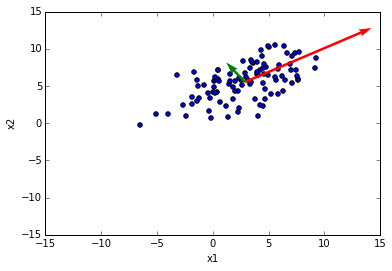

In [23]:
hw = 15
df.plot(x="x1", y='x2', kind='scatter', ylim=(-hw,hw),xlim=(-hw,hw))
x, y = df.x1.mean(), df.x2.mean()
u1, v1 = eig_vecs[:,0] * eig_vals[0]
u2, v2 = eig_vecs[:,1] * eig_vals[1]
plt.quiver(x, y, u1, v1, angles='xy', scale_units='xy',scale=1,color='r')
plt.quiver(x, y, u2, v2, angles='xy', scale_units='xy',scale=1,color='g')

## 5.e

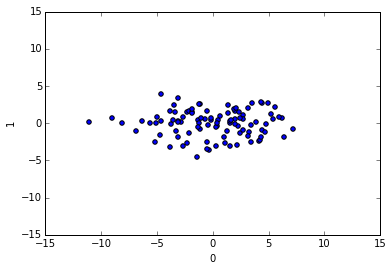

In [24]:
U = eig_vecs
x1_prep = x1s - np.mean(x1s)
x2_prep = x2s - np.mean(x2s)
points = [U.T.dot(x) for x in zip(x1_prep, x2_prep)]
pd.DataFrame(np.array(points)).plot(x=0, y=1, kind='scatter', ylim=(-hw,hw),xlim=(-hw,hw))

# 6 

## 6.a

$ \Sigma^{-1} $ will not exist when our columns are linearly dependent on one another or when they contain duplicate information. All eigenvalues must be positive as well.

A transformation we can apply is to remove the duplicate columns/hyper correlated features and more generally duplicate information. All diagonal values must be non-zero. (Gaussian Elimination).

## 6.b

$$ x^T \Sigma^{-1} x = ||Ax||^2_2 $$

$$  x^T \Sigma^{-1} x = x^TA^TAx $$

$$ \Sigma^{-1} = A^TA $$

$$(U S^{2} U^T)^{-1} = A^TA $$

$ S = $ singular values 

$$U S^{-1} S^{-1} U^T = A^TA $$

$$ S^{-1} U^T = A $$

## 6.c

By doing this conversion we're revealing that we're really just measuring a kind of distance from the mean with our probability. We're converting probability into a distance by looking at the distance measures along the eigenvector axes. Fundamentally the covariance is a measurement from the mean.

## 6.d

$C = ||Ax||^2_2 $. To get the minimum value of C, since we’ve decomposed this we know that basically A will represent S^-1 and U^T.  Those two together make the diagonal covariance matrix combined with the column eigenvectors. Since we have this x constraint we’re basically doing this dot product diagonal covariance matrix + eigenvectors and some vector x. To maximize or minimize C, we create a x as a vector of $[0,..,..1]$ where the 1 is at the location of greatest variance or 1 is at the location of least variance respectively.

Intuitively we will have maximum or minimum of the direction and power of covariance. This has the effect of selecting the dimension with the most (or least) variance, since there are only diagonal values in the matrix.

The Maximum value of $||Ax_2^2||$ would be the smallest probability while minimum is the one with the highest probability of belonging to the class. Because we've got this distance measure now, we're intuitively trying to get an $x$ value that would minimize the distance measure $||Ax||^2_2$ (while constrained by $||x||_2$). Doing this would maximize the probability of f(x).

# 7

In [25]:
from scipy.stats import multivariate_normal

dig_train = scipy.io.loadmat("data/train.mat")
dig_X = dig_train['train_images'].T.reshape((60000,784))
dig_y = dig_train['train_labels'].reshape(60000,)
shuff = np.arange(len(dig_y))
np.random.shuffle(shuff)
dig_X_train = dig_X[shuff]/255
dig_y_train = dig_y[shuff]
dig_val_X = dig_X_train[50000:]
dig_val_y = dig_y_train[50000:]
dig_X_train = dig_X_train[:50000]
dig_y_train = dig_y_train[:50000]


dig_test = scipy.io.loadmat("data/test.mat")
dig_X_test = dig_test['test_images']
dig_y_test = dig_test['test_labels'].reshape((10000))

print(dig_X_train.shape,dig_y_train.shape, dig_X_test.shape, dig_y_test.shape) # make sure our shapes are good

(50000, 784) (50000,) (10000, 784) (10000,)


## 7.a

The maximum likelihood estimates for the mean and the covariance matrix of a Gaussian

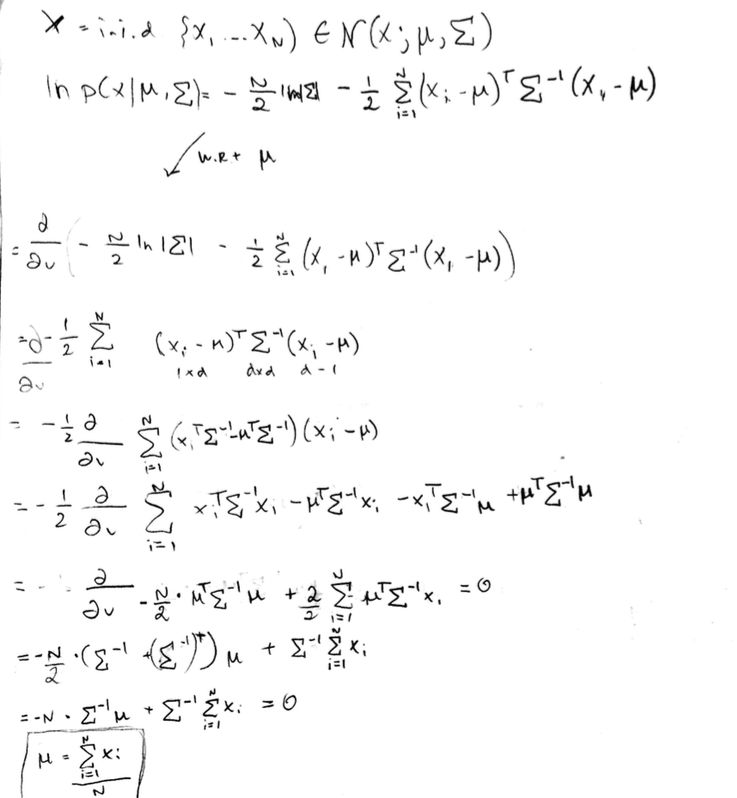

In [26]:
Image("7a.png")

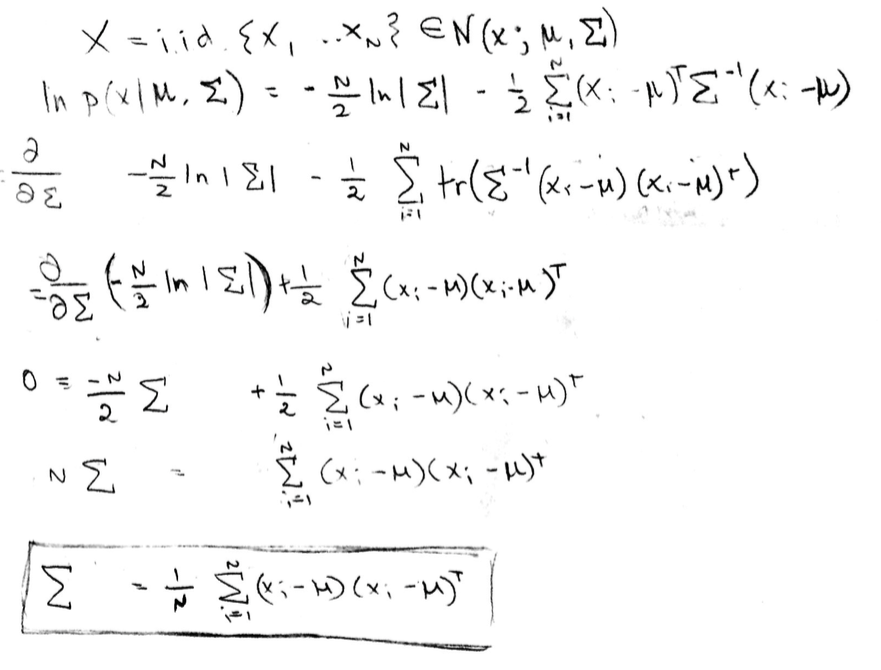

In [27]:
Image("7a2.png")

## 7.b

You can compute priors by seeing the density of a given value in the training set.

In [28]:
priors = pd.Series(dig_y_train).value_counts() / len(dig_y_train)
priors

1    0.11236
7    0.10452
3    0.10182
9    0.09928
2    0.09902
8    0.09884
0    0.09866
6    0.09848
4    0.09702
5    0.09000
dtype: float64

In [29]:
means = {}
for num in range(10):
    means[num] = dig_X_train[dig_y_train == num].mean(axis=0)

## 7.c

In [30]:
import seaborn as sns

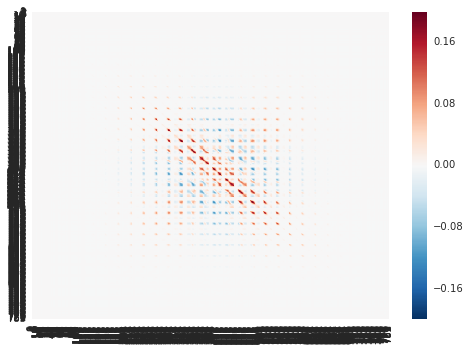

In [31]:
sns.heatmap(np.cov(dig_X_train[dig_y_train == 1].T))

These visualizations show how the various pixels covary with one another. I've chosen to visualize a 1. In this image we can see clearly that the image has been padded, because there seems to be a frame around the entire covariance. Additionally we can see that there seems to be little covariance in the center, this is because for a one, everyone draws a line through the center however we see variance around that because sometimes the ones arc left or arc right.

## 7.d

### i

In [32]:
def get_mu_sigma(X_, y_, labels, alpha):
    mus = []
    for label in labels:
        vals = X_[y_ == label]
        mus.append(np.mean(vals, axis=0))
    sigma = np.cov(X_.T)
    np.fill_diagonal(sigma, alpha + np.diag(sigma))
    return mus, sigma

def train_gaussian(mus, sigma, labels):
    classes = []
    for label in labels:
        model = multivariate_normal(mus[label], sigma)
        classes.append((label, model))
    return classes

def classify_gaussian(labels_models, X):
    outputs = []
    for label, model in labels_models:
        outputs.append(model.logpdf(X))
    return np.array(outputs).argmax(axis=0)

def test_gaussian(labels_models, X, y):
    y_hat = classify_gaussian(labels_models, X)
    return np.sum(y != y_hat) / len(y)

def run_mv(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigma = get_mu_sigma(Xs, Ys, range(10), alpha)
        classes = train_gaussian(mus, sigma, range(10))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print('Train Error: ', error_rate,'Test Error: ', test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "vaidation_error": test_error_rates, 
            "train_amount": trial_amounts}

In [33]:
errors = run_mv(dig_X_train, dig_y_train, dig_val_X, dig_val_y, 0.001)

Trained on  100
Train Error:  0.46804 Test Error:  0.4704
Trained on  200
Train Error:  0.44496 Test Error:  0.4511
Trained on  500
Train Error:  0.40356 Test Error:  0.4116
Trained on  1000
Train Error:  0.3205 Test Error:  0.3328
Trained on  2000
Train Error:  0.25576 Test Error:  0.2703
Trained on  5000
Train Error:  0.2097 Test Error:  0.2245
Trained on  10000
Train Error:  0.19196 Test Error:  0.2091
Trained on  30000
Train Error:  0.18066 Test Error:  0.1987
Trained on  50000
Train Error:  0.1789 Test Error:  0.1955


,train_amount,train_error,vaidation_error
0,100,0.46804,0.4704
1,200,0.44496,0.4511
2,500,0.40356,0.4116
3,1000,0.32050,0.3328
4,2000,0.25576,0.2703
5,5000,0.20970,0.2245
6,10000,0.19196,0.2091
7,30000,0.18066,0.1987
8,50000,0.17890,0.1955


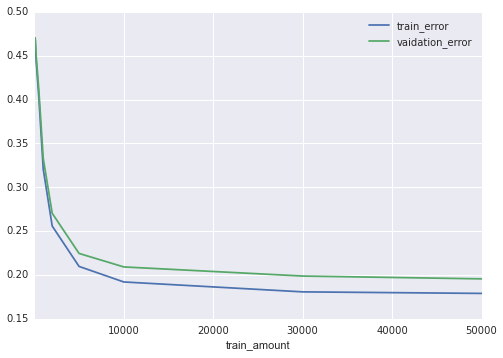

In [34]:
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

The form of the decision boundary is linear because we assume that each grouping/class/cluster has the same variance. This is because they all occupy the same fundamental amount space in our X-space, we're basically drawing linear boundaries in between each class and all the others.

### ii

In [35]:
def get_mu_sigma2(X_, y_, labels, alpha):
    mus = []
    sigmas = []
    for label in labels:
        vals = X_[y_ == label]
        mus.append(np.mean(vals, axis=0))
        sigma = np.cov(vals.T)
        np.fill_diagonal(sigma, alpha + np.diag(sigma))
        sigmas.append(sigma)
    return mus, sigmas

def train_gaussian2(mus, sigmas, labels):
    classes = []
    for label in labels:
        model = multivariate_normal(mus[label], sigmas[label])
        classes.append((label, model))
    return classes

def run_mv2(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigmas = get_mu_sigma2(Xs, Ys, range(10), alpha)
        classes = train_gaussian2(mus, sigmas, range(10))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print('Train Error: ', error_rate,'Test Error: ', test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "test_error": test_error_rates, 
            "train_amount": trial_amounts}

In [36]:
errors = run_mv2(dig_X_train, dig_y_train, dig_val_X, dig_val_y, 0.001)

Trained on  100
Train Error:  0.31408 Test Error:  0.3142
Trained on  200
Train Error:  0.21934 Test Error:  0.2219
Trained on  500
Train Error:  0.16576 Test Error:  0.1688
Trained on  1000
Train Error:  0.13348 Test Error:  0.1369
Trained on  2000
Train Error:  0.11266 Test Error:  0.1215
Trained on  5000
Train Error:  0.1085 Test Error:  0.1287
Trained on  10000
Train Error:  0.1 Test Error:  0.1266
Trained on  30000
Train Error:  0.08622 Test Error:  0.1278
Trained on  50000
Train Error:  0.0836 Test Error:  0.1266


,test_error,train_amount,train_error
0,0.3142,100,0.31408
1,0.2219,200,0.21934
2,0.1688,500,0.16576
3,0.1369,1000,0.13348
4,0.1215,2000,0.11266
5,0.1287,5000,0.10850
6,0.1266,10000,0.10000
7,0.1278,30000,0.08622
8,0.1266,50000,0.08360


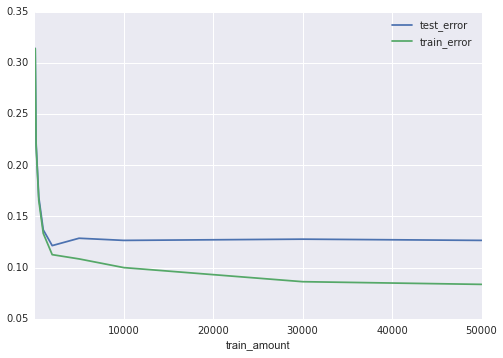

In [37]:
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

This is a non-linear decision boundary because we vary our covariance matrix with the class. This makes it non-linear because th progressions are not constant and can interweave more than they could with a constant covariance matrix.

### iii

The difference between these two is whether or not we assume they fundamentally share the same covariance matrix(i) or if they have their own individual covariance matrices(ii). When we assume that each class has its own covariance matrix we can see that some samples of our data seem to be better representations than others, for example the 500 and 1000 sets have a very small training and test error. This means that they generalize better than the 5000 sample that we pulled.

### iv

In [38]:
dig_kaggle_X = scipy.io.loadmat("kaggle/test.mat")['test_images']/255
dig_kaggle_X.shape

(10000, 784)

In [39]:
mus, sigma = get_mu_sigma(dig_X_train, dig_y_train, range(10), 0.001)
classes = train_gaussian(mus, sigma, range(10))
y_hat = classify_gaussian(classes, dig_kaggle_X)

In [40]:
yh = pd.DataFrame({"Category":y_hat, "Id":range(1,1+len(y_hat))})
yh.to_csv("out.csv",index=False)

Best Kaggle: 0.82160

## 7.e

In [41]:
from scipy.stats import multivariate_normal

spam_train = scipy.io.loadmat("data/spam_data.mat")
spam_X = spam_train['training_data']
spam_y = spam_train['training_labels'].T.reshape((5172,))
print(spam_X.shape, spam_y.shape)
shuff = np.arange(len(spam_y))
np.random.shuffle(shuff)
spam_X_train = spam_X[shuff]
spam_y_train = spam_y[shuff]
train_test_amount = 3500
spam_val_X = spam_X_train[train_test_amount:]
spam_val_y = spam_y_train[train_test_amount:]
spam_X_train = spam_X_train[:train_test_amount]
spam_y_train = spam_y_train[:train_test_amount]

spam_X_test = spam_train['test_data']

print(spam_X_train.shape,spam_y_train.shape, spam_val_X.shape) # make sure our shapes are good

(5172, 32) (5172,)
(3500, 32) (3500,) (1672, 32)


In [42]:
def run_mv_spam(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 4000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigma = get_mu_sigma(Xs, Ys, range(2), alpha)
        classes = train_gaussian(mus, sigma, range(2))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print(error_rate,test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "vaidation_error": test_error_rates, 
            "train_amount": trial_amounts}

def run_mv2_spam(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 4000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigmas = get_mu_sigma2(Xs, Ys, range(2), alpha)
        classes = train_gaussian2(mus, sigmas, range(2))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print('Train Error: ', error_rate,'Test Error: ', test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "test_error": test_error_rates, 
            "train_amount": trial_amounts}

Trained on  100
0.241142857143 0.230861244019
Trained on  200
0.234857142857 0.213516746411
Trained on  500
0.204571428571 0.196172248804
Trained on  1000
0.193142857143 0.197966507177
Trained on  2000
0.194571428571 0.198564593301
Trained on  3500
0.192285714286 0.196770334928


,train_amount,train_error,vaidation_error
0,100,0.241143,0.230861
1,200,0.234857,0.213517
2,500,0.204571,0.196172
3,1000,0.193143,0.197967
4,2000,0.194571,0.198565
5,4000,0.192286,0.196770


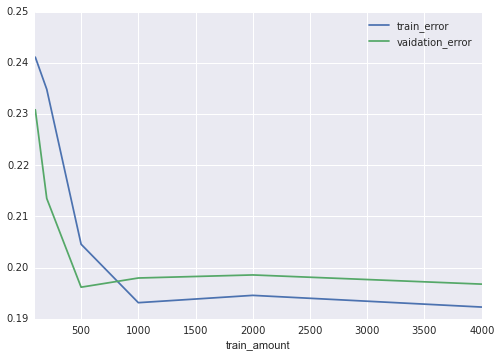

In [43]:
errors = run_mv_spam(spam_X_train, spam_y_train, spam_val_X, spam_val_y, 0.001)
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

Trained on  100
Train Error:  0.278857142857 Test Error:  0.308612440191
Trained on  200
Train Error:  0.340857142857 Test Error:  0.364234449761
Trained on  500
Train Error:  0.353142857143 Test Error:  0.393540669856
Trained on  1000
Train Error:  0.348285714286 Test Error:  0.38456937799
Trained on  2000
Train Error:  0.207142857143 Test Error:  0.202751196172
Trained on  3500
Train Error:  0.206571428571 Test Error:  0.203947368421


,test_error,train_amount,train_error
0,0.308612,100,0.278857
1,0.364234,200,0.340857
2,0.393541,500,0.353143
3,0.384569,1000,0.348286
4,0.202751,2000,0.207143
5,0.203947,4000,0.206571


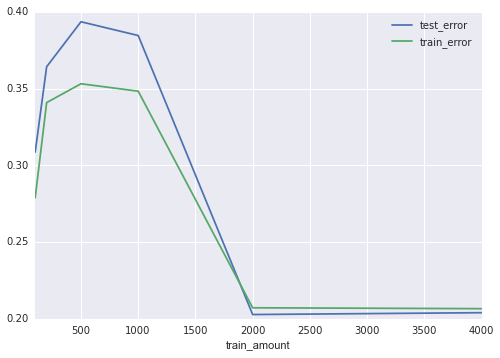

In [44]:
errors = run_mv2_spam(spam_X_train, spam_y_train, spam_val_X, spam_val_y, 0.001)
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

In [45]:
mus, sigma = get_mu_sigma2(spam_X_train, spam_y_train, range(2), 0.001)
classes = train_gaussian2(mus, sigma, range(2))
y_hat = classify_gaussian(classes, spam_X_test)

In [46]:
yh = pd.DataFrame({"Category":y_hat, "Id":range(1,1+len(y_hat))})
yh.to_csv("out_spam2.csv",index=False)

Best Kaggle: 0.74660